In [8]:

%load_ext autoreload
%autoreload 2

import shap
from tqdm import tqdm

from util.util_pickle import save_data, load_data
from util.util_cnn import data_loaders, first_mnist_batch, load_mnist_v4_models
from util.common import HiddenPrints
from util.util_gamma_rule import calc_vals_batch
from util.util_data_summary import *

from util.naming import d3_tag, PICKLE_PATH
import numpy as np
import matplotlib.pyplot as plt

# load model
model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

data, target = first_mnist_batch(batch_size=10000)
data.shape, target.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(torch.Size([8400, 1, 28, 28]), torch.Size([8400]))

In [17]:
# config
config = {
    'background_size': 100,
    'batch_size': 10,
    'model': d3_tag
}
# config = dict(sorted(config.items()))

n_points = 100
l_out = 15

# load training data as shap background
background, background_target = first_mnist_batch(batch_size=config["background_size"], test=False)
background = background.reshape((-1, 1, 28, 28))
submodel = model_d3.seq[:l_out]
e = shap.DeepExplainer(submodel, background)

In [43]:
## runs 80 to 246 mins
if False:
    with HiddenPrints(): shaps = e.shap_values(data[:n_points])      # dimensions: [num_classes, [datapoints, channels, x, y]]
    shaps = np.stack(shaps).transpose((1, 0, 2, 3, 4))          # dimensions: [datapoints, num_classes, channels, x, y]
    save_data('d3', f'Rels__{n_points}_to_0__testset{n_points}__shap__background_size-100__batch_size-10', shaps)
    
    if l_out == 'm0': # Rel0 only makes sense in the last layer, as we need the target class.
        shaps_target_class = {'shap__background_size-100__batch_size-10': shaps[np.arange(len(shaps)), target[:len(shaps)]]}
        save_data('d3', f'Rel0__{n_points}_to_0__testset{n_points}__shap__background_size-100__batch_size-10', shaps_target_class)
        print(shaps_target_class.keys(), shaps_target_class[next(iter(shaps_target_class))].shape)
else:
    shaps              = load_data("d3", f'Rels__{l_out}_to_0__testset{n_points}__shap__background_size-100__batch_size-10')
    if l_out == 'm0': # Rel0 only makes sense in the last layer, as we need the target class.
        shaps_target_class = load_data("d3", f'Rel0__{l_out}_to_0__testset{n_points}__shap__background_size-100__batch_size-10')
        print(shaps_target_class.keys(), shaps_target_class[next(iter(shaps_target_class))].shape)

shaps.shape # (n_points, 10, 1, 28, 28)

Attempt loading: d3 Rels__15_to_0__testset100__shap__background_size-100__batch_size-10


(100, 256, 1, 28, 28)

In [38]:
shaps.shape

(100, 256, 1, 28, 28)

In [42]:
shaps_target_class['shap__background_size-100__batch_size-10'].shape

(100, 1, 28, 28)

## Normalize

In [49]:
mats[0].shape, output.shape

((100, 1, 256, 1, 28, 28), torch.Size([100, 256]))

In [66]:
n_points = 100
l_out = 15

prefilter_positive_activations, first_p = True, 80
all_logits = False
normalized = True

key = key_rels = f'__{l_out}_to_0__testset{n_points}__shap__background_size-100__batch_size-10'

if not normalized: key += '__unnormalized'
if all_logits: key += '__all_logits'
if first_p: key += f'__p{first_p:03}'

if True:
    from util.data_wrangling import mask_unactivated__normalize__reshape
    
    n_points_save = 100000
    mats = load_data("d3", 'Rels'+key_rels)
    mats = mats[:n_points_save]
    output = submodel(data[:min(n_points, n_points_save)]).detach()
    
    mats = mats[None, :, None] # add a dummy dimension for different subsections of the network, and one for different parametrisation of the method
    mats = mask_unactivated__normalize__reshape(mats, output, prefilter_positive_activations=prefilter_positive_activations, first_p=first_p)
    
    save_data("d3", 'mats'+key, mats)
else: 
    mats = load_data("d3", 'mats'+key)
    
len(mats), mats[0].shape, mats[0][0,0].shape

Attempt loading: d3 Rels__15_to_0__testset100__shap__background_size-100__batch_size-10
subsection 0: (100, 1, 256, 1, 28, 28)  ->  (100, 1) (85, 784)
Saved: ./pickle/d3/mats__15_to_0__testset100__shap__background_size-100__batch_size-10__p080.pickle


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(1, (100, 1), (85, 784))

In [67]:
if True:
    mats = load_data("d3", 'mats'+key)
    vals = calc_vals_batch(mats, num_vals='auto', tqdm_for='point', return_vecs=False)
    save_data('d3', 'svals'+key, vals)
else:
    vals = load_data('d3', 'svals'+key)
    
vals.shape

Attempt loading: d3 mats__15_to_0__testset100__shap__background_size-100__batch_size-10__p080


0it [00:00, ?it/s]

100it [00:06, 14.57it/s]

Saved: ./pickle/d3/svals__15_to_0__testset100__shap__background_size-100__batch_size-10__p080.pickle


(1, 100, 1, 112)

(1, 8400)


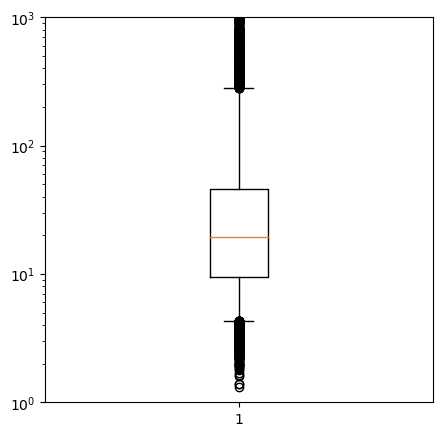

In [52]:
ylim = (1,1000)

d = condition_number(vals, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
if len(d)==1: axs=[axs]
for ax, d in zip(axs, d):
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

(1, 8400)


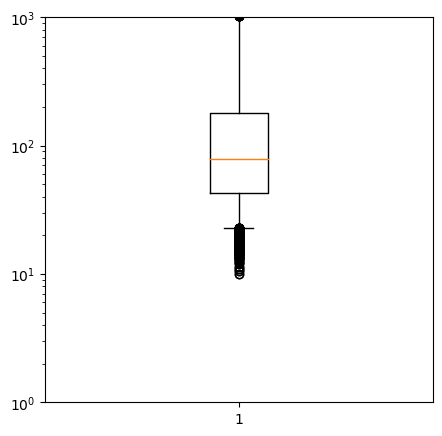

In [50]:
ylim = (1,1000)

d = condition_number(vals, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
if len(d)==1: axs=[axs]
for ax, d in zip(axs, d):
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

## Before introducing normalization to SHAP matrices
(we don't force matrix columns to sum to 1.)

In [4]:
if True:
    from util.data_wrangling import mask_unactivated__normalize__reshape

    mats_unnormalized = load_data("d3", 'Rels__m0_to_0__testset__shap__background_size-100__batch_size-10')
    
    mats_unnormalized = mats_unnormalized[None, :, None] # add a dummy dimension for different subsections of the network, and one for different parametrisation of the method
    mats_unnormalized = mask_unactivated__normalize__reshape(mats_unnormalized, model_d3(data), normalize=False)
    

    save_data("d3", 'mats__m0_to_0__testset__shap__background_size-100__batch_size-10__unnormalized', mats_unnormalized)
else: 
    mats_unnormalized = load_data("d3", 'mats__m0_to_0__testset__shap__background_size-100__batch_size-10__unnormalized')
    
len(mats_unnormalized), mats_unnormalized[0].shape

Attempt loading: d3 Rels__m0_to_0__testset__shap__background_size-100__batch_size-10
subsection 0: (8400, 1, 10, 1, 28, 28)  ->  (8400, 1, 10, 784)
Saved: ./pickle/d3/mats__m0_to_0__testset__shap__background_size-100__batch_size-10__unnormalized.pickle


(1, (8400, 1, 10, 784))

In [17]:
key = ('d3', 'svals__m0_to_0__testset__shap__background_size-100__batch_size-10__unnormalized')
if False:
    vals_unnormalized = calc_vals_batch(mats_unnormalized, num_vals='auto', tqdm_for='point', return_vecs=False)
    save_data(*key, vals_unnormalized)
else:
    vals_unnormalized = load_data(*key)
    
vals_unnormalized.shape

8400it [00:01, 7581.76it/s]


(1, 8400, 1, 7)

(1, 8400)


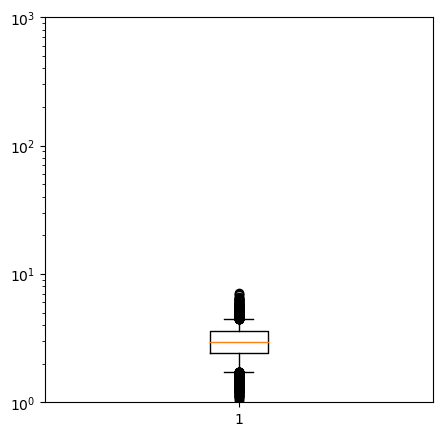

In [18]:
ylim = (1,1000)

d = condition_number(vals_unnormalized, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
if len(d)==1: axs=[axs]
for ax, d in zip(axs, d):
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

### Background 400 (don't rerun, we don't have the data)

(1, 20)


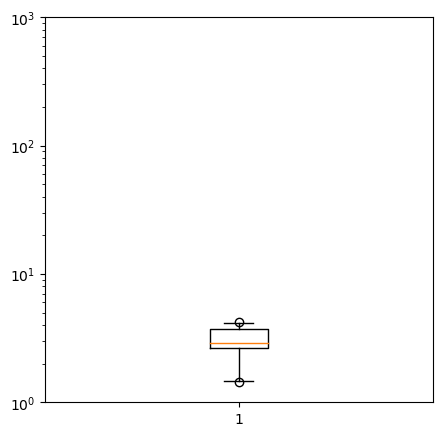

In [ ]:
ylim = (1,1000)

d = condition_number(vals, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
if len(d)==1: axs=[axs]
for ax, d in zip(axs, d):
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

## L1 operator norm of shap (with and without normalization):

In [34]:
np.abs(mats_unnormalized[0][4]).sum(axis=(2)).max(), np.abs(mats[0][4]).sum(axis=(2)).max()

(18.261970860230164, 8.801821393790028)

## PixelFlippin
(copied most of the code from run-pixflip-pool)

In [67]:
import quantus

from util.quantus import *

In [84]:
device=torch.device("mps")
model=model_d3
model.eval()
model.to(device)

perturb_func=None
perturb_baseline="mean"
for perturb_baseline in ["mean", "black", "white"]:
    pixFlipMetric = quantus.PixelFlipping(disable_warnings = True, perturb_func=perturb_func, perturb_baseline=perturb_baseline)

    def flipScores(x_batch, y_batch, a_batch):
        return pixFlipMetric(

            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            device=device
        )

    x_batch = data.numpy()
    y_batch = target.numpy()
    a_batch = shaps[np.arange(len(shaps)), y_batch]

    n = 50
    np.random.seed(42)
    scores = []
    assert len(x_batch) == len(y_batch) == len(a_batch), f"Not matching shape: {x_batch.shape}, {y_batch.shape}, {a_batch.shape}"

    for i in tqdm(range(0, len(a_batch), n)):
        # create minibatches to pass to pixflip system
        xb = x_batch[i:i+n]
        yb = y_batch[i:i+n]
        ab = a_batch[i:i+n]
        assert len(xb) == len(yb) == len(ab), f"Not matching shape: {xb.shape}, {yb.shape}, {ab.shape}"

        minibatch_scores = flipScores(xb, yb, ab)
        scores.append(minibatch_scores)

    shared_dict_scores = {}
    shared_dict_scores["background_size-100__batch_size-10"] = { 'PixFlip': np.concatenate(scores, axis=0) }
    save_data('d3', f'PixFlipScores__testset__{perturb_baseline}__background_size-100__batch_size-10', shared_dict_scores)

(8400,)
(8400, 1, 28, 28)


  0%|          | 0/168 [00:00<?, ?it/s]

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
100%|██████████| 168/168 [7:16:07<00:00, 155.76s/it]  


(8400,)
(8400, 1, 28, 28)


100%|██████████| 168/168 [4:30:49<00:00, 96.72s/it]   


(8400,)
(8400, 1, 28, 28)


100%|██████████| 168/168 [3:55:41<00:00, 84.18s/it]    


## check results of different methods

In [90]:
dic = load_data('d3', f'PixFlipScores__testset__mean__background_size-100__batch_size-10')
dic["background_size-100__batch_size-10"]['PixFlip'].shape

(8400, 784)

In [89]:
dic = load_data('d3', f'PixFlipScores__testset2__mean__all_gamma__gammas80')
dic[next(iter(dic))]['PixFlip'].shape

(2, 784)

In [95]:
relevancies_per_mode[next(iter(relevancies_per_mode))].shape

torch.Size([100, 1, 28, 28])

In [ ]:
relevancies_per_mode[next(iter(relevancies_per_mode))].shape

(4000, 1, 10, 784)

## Helpers

### Run on mps?

In [19]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/mps/MPSFallback.mm:11.)


### Time shap per batch size

In [40]:
import time

# Assuming data is your dataset
num_runs = 10  # or however many runs you want to do
num_datapoints = 2 ** np.arange(5)
times = []
for n in num_datapoints:
    start_time = time.time()
    with HiddenPrints(): 
        vals = e.shap_values(data[:n])  # dimensions: [num_classes, [datapoints, channels, x, y]]
    vals = np.stack(vals).transpose((1, 0, 2, 3, 4))  # dimensions: [datapoints, num_classes, channels, x, y]
    end_time = time.time()
    times.append(end_time - start_time)
    print(end_time - start_time)

print(times)

0.7571961879730225
1.4866139888763428
2.9086108207702637
5.904338836669922
11.77690076828003
[0.7571961879730225, 1.4866139888763428, 2.9086108207702637, 5.904338836669922, 11.77690076828003]


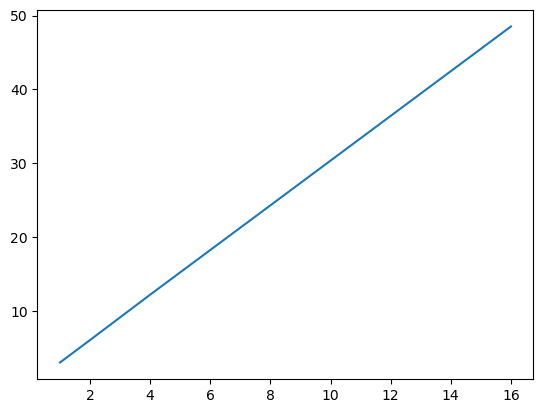

In [15]:
times_400 = [3.007702112197876, 6.051133871078491, 12.198693752288818, 24.302546977996826, 48.533602237701416]
times_100
plt.plot(num_datapoints, times)